<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w5_bike_webinar_regr_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is my task? What do I want to do?

* We have the publicly available dataset for bike rides. In that dataset we have each day described by a set of factors involving time/date, weather conditions, ..., and the number of bike rides. It would nice to be able to estimate the number of bikes rides for future days - why? - predicting demand is useful, as we can then get prepared, take action, before things happen.

* Predicting demand is a typical thing in the real-world - think about energy companies - it is expensive to store energy, at the same time you don't want to be caught out if demand suddenly increases...

## Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# latest version of scikit-learn: might need a kernel restart
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.1 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder

In [ ]:
!pip install --upgrade category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
from category_encoders import TargetEncoder

## What does the data look like?

In [ ]:
bikes = pd.read_csv('https://github.com/gerberl/6G7V0017-2324/raw/main/datasets/bike.csv')

In [ ]:
bikes.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


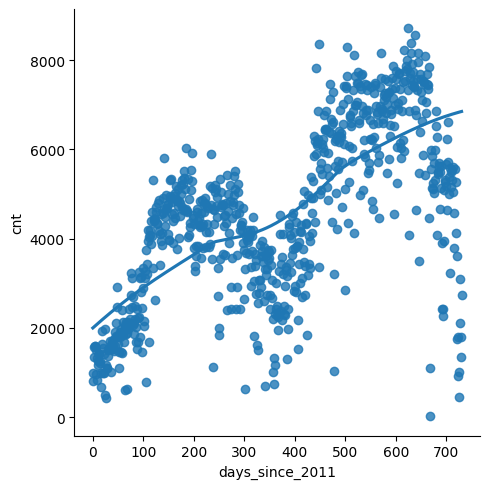

In [ ]:
# How could we analyse how `cnt` varies with `days_since_2011`?
sns.lmplot(data=bikes, x='days_since_2011', y='cnt', lowess=True);

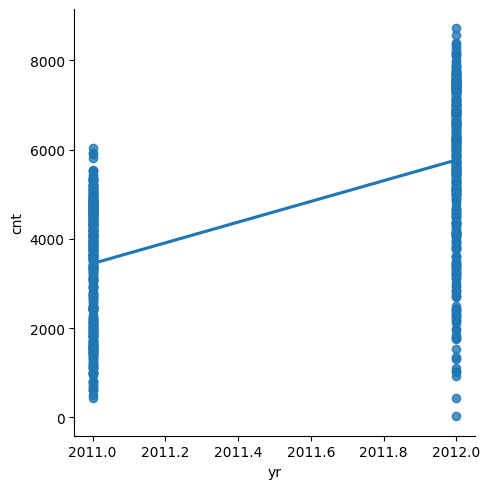

In [ ]:
sns.lmplot(data=bikes, x='yr', y='cnt', lowess=True);

* For this dataset, containing only two years, I would agree with you all and probably drop `yr` - at the moment, what it is helping us slightly is with providing us with some trend information over time.

* If we didn't have `days_since_2011`, we could probably have engineered it from `year` and other date/time-related features.

* But... Let us say that we have a larger period. And let us assume that some *incidents/events* are associated with particular years. And that those events would have an impact on demand. Would you keep it? Would you engineer something from it?

In [ ]:
bikes.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'days_since_2011'],
      dtype='object')

In [ ]:
bikes['season'].value_counts(normalize=True)

SUMMER    0.257182
SPRING    0.251710
WINTER    0.247606
FALL      0.243502
Name: season, dtype: float64

* Do we keep `season`? Isn't weather conditions (associated with seasons, to a certain extent) enough?

<Axes: xlabel='season', ylabel='cnt'>

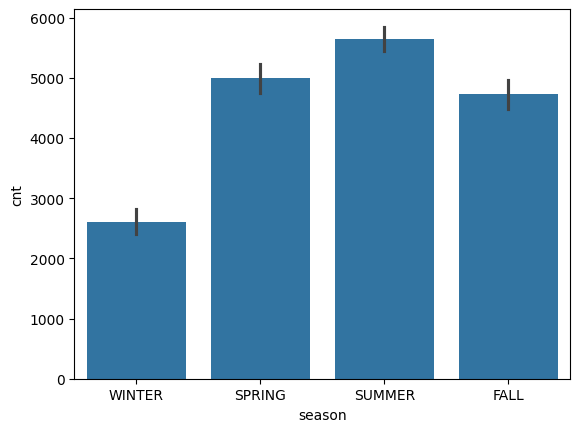

In [ ]:
sns.barplot(data=bikes, x='season', y='cnt')

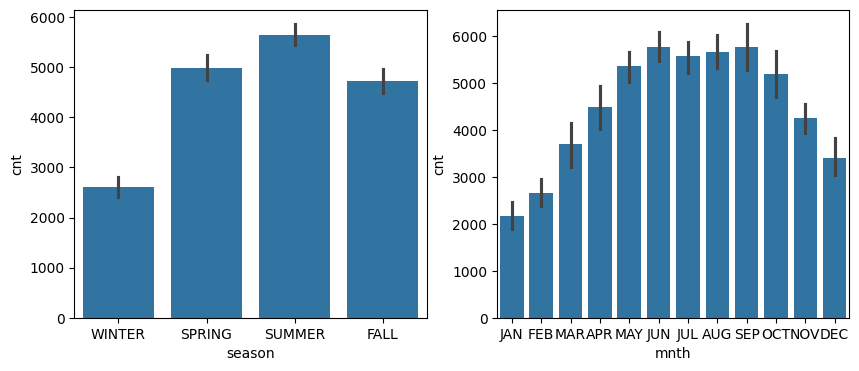

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=bikes, x='season', y='cnt', ax=axs[0])
sns.barplot(data=bikes, x='mnth', y='cnt', ax=axs[1]);

In [ ]:
bikes.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
bikes = bikes.drop(columns='yr')
bikes.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


## Prepare Data for Machine Learning

The usual separation of features and target.

In [ ]:
X = bikes.drop(columns='cnt')
y = bikes['cnt']

We need train and test - we save the latter for estimating the performance of the models on data they have not seen.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2
)

Are we doing any categorical encoding?

In [ ]:
X_train.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

In [ ]:
cat_feat = X_train.select_dtypes(include='object').columns

In [ ]:
num_feat = X_train.select_dtypes(exclude='object').columns

In [ ]:
num_feat

Index(['temp', 'hum', 'windspeed', 'days_since_2011'], dtype='object')

## Configuring and Training a Random Forest

In [ ]:
ohe = OneHotEncoder(sparse_output=False)
tgte = TargetEncoder()

In [ ]:
ohe.fit(X_train[cat_feat])
tgte.fit(X_train[cat_feat], y_train)

TargetEncoder(cols=['season', 'mnth', 'holiday', 'weekday', 'workingday',
                    'weathersit'])

In [ ]:
X_train[cat_feat].head(1)

,season,mnth,holiday,weekday,workingday,weathersit
97,SPRING,APR,NO HOLIDAY,FRI,WORKING DAY,MISTY


In [ ]:
# ohe.transform(X_train[cat_feat])
tgte.transform(X_train[cat_feat], y_train)

,season,mnth,holiday,weekday,workingday,weathersit
97,4875.861138,4207.814589,4511.091549,4682.652968,4548.561881,4112.295927
503,4875.861138,5279.459260,4511.091549,4682.652968,4548.561881,4807.131367
642,4637.252946,5120.939366,4511.091549,4665.819382,4548.561881,4112.295927
498,4875.861138,5279.459260,4511.091549,4349.503177,4375.716680,4807.131367
303,4637.252946,5120.939366,4511.091549,4157.030272,4548.561881,4807.131367
...,...,...,...,...,...,...
707,4637.252946,3512.715091,4511.091549,4488.379873,4375.716680,4112.295927
192,5728.441047,5485.153068,4511.091549,4639.191996,4548.561881,4807.131367
629,5728.441047,5810.026205,4511.091549,4682.652968,4548.561881,4807.131367
559,5728.441047,5485.153068,4511.091549,4682.652968,4548.561881,4112.295927


In [ ]:
X_train_pp = pd.concat(
    [
        tgte.transform(X_train[cat_feat]),
        X_train[num_feat]
    ],
    axis='columns'
)
X_test_pp = pd.concat(
    [
        tgte.transform(X_test[cat_feat]),
        X_test[num_feat]
    ],
    axis='columns'
)

In [ ]:
X_train_pp.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,4875.861138,4207.814589,4511.091549,4682.652968,4548.561881,4112.295927,7.784151,83.6250,15.208464,97
503,4875.861138,5279.459260,4511.091549,4682.652968,4548.561881,4807.131367,18.515849,52.3333,9.166739,503
642,4637.252946,5120.939366,4511.091549,4665.819382,4548.561881,4112.295927,22.902500,72.2917,7.875582,642
498,4875.861138,5279.459260,4511.091549,4349.503177,4375.716680,4807.131367,20.787500,57.6250,15.082839,498
303,4637.252946,5120.939366,4511.091549,4157.030272,4548.561881,4807.131367,7.980000,70.3333,7.125450,303


I'll try first my usual go-to model - a default RandomForest regressor.

For trees/tree ensembles, scaling/interactions are normally not necessary.

For linear models, kNN models, ..., it is always a good idea to scale data (so that one feature measured in a scale of hundreds doesn't dominate over another of tens...)

Bear in mind the trade-offs - scaling can be detrimental to explainability...

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()

In [ ]:
rfr.fit(X_train_pp, y_train)

RandomForestRegressor()

In [ ]:
rfr.score(X_train_pp, y_train)

0.9804795911870073

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_train, rfr.predict(X_train_pp))

179.14991438356165

In [ ]:
rfr.score(X_test_pp, y_test)

0.8994545390970614

In [ ]:
mean_absolute_error(y_test, rfr.predict(X_test_pp))

481.64061224489797

## Configuring and Fitting a kNN Regressor

In [ ]:
# we would like to scale the data first
# it affects the performance of kNN models

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

StandardScaler()

In [ ]:
scaler.transform(X_train[num_feat]).head(1)

,temp,hum,windspeed,days_since_2011
97,-0.845148,1.517365,0.490775,-1.258346


In [ ]:
X_train_enc = pd.concat(
        [
            tgte.transform(X_train[cat_feat]),
            X_train[num_feat]
        ],
        axis='columns'
    )

In [ ]:
X_train_enc.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,4875.861138,4207.814589,4511.091549,4682.652968,4548.561881,4112.295927,7.784151,83.625,15.208464,97


In [ ]:
scaler.fit(X_train_enc)

StandardScaler()

In [ ]:
X_train_pp = scaler.transform(X_train_enc)
X_train_pp.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,0.341637,-0.256778,0.167836,1.058766,0.667491,-1.153122,-0.845148,1.517365,0.490775,-1.258346


In [ ]:
X_test_enc = pd.concat(
        [
            tgte.transform(X_test[cat_feat]),
            X_test[num_feat]
        ],
        axis='columns'
    )

In [ ]:
X_test_pp = scaler.transform(X_test_enc)
X_test_pp.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
196,1.106993,0.887194,0.167836,-0.039285,-1.498147,0.723472,1.060122,-0.276179,0.246691,-0.791786


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knnr = KNeighborsRegressor(5)

In [ ]:
knnr.fit(X_train_pp, y_train)

KNeighborsRegressor()

In [ ]:
mean_absolute_error(y_train, knnr.predict(X_train_pp))

506.4732876712328

In [ ]:
mean_absolute_error(y_test, knnr.predict(X_test_pp))

732.5238095238095

## Ensemble of those two?

* Homework?
* Any challenges?
* Better results?
* Any other models to put together in an ensemble?